In [14]:
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.insert(0, "../")
from hellaswag import download, render_example, iterate_examples

hs = iterate_examples("val") 
example = next(hs)
print(example)

{'ind': 24, 'activity_label': 'Roof shingle removal', 'ctx_a': 'A man is sitting on a roof.', 'ctx_b': 'he', 'ctx': 'A man is sitting on a roof. he', 'split': 'val', 'split_type': 'indomain', 'label': 3, 'endings': ['is using wrap to wrap a pair of skis.', 'is ripping level tiles off.', "is holding a rubik's cube.", 'starts pulling up roofing on a roof.'], 'source_id': 'activitynet~v_-JhWjGDPHMY'}


In [9]:
rendered = render_example(example)
rendered

({'label': 3,
  'ctx_tokens': [32, 582, 318, 5586, 319, 257, 9753, 13, 339],
  'ending_tokens': [[318,
    1262,
    14441,
    284,
    14441,
    257,
    5166,
    286,
    1341,
    271,
    13],
   [318, 34759, 1241, 19867, 572, 13],
   [318, 4769, 257, 6437, 1134, 338, 23441, 13],
   [4940, 10427, 510, 9753, 278, 319, 257, 9753, 13]]},
 tensor([[   32,   582,   318,  5586,   319,   257,  9753,    13,   339,   318,
           1262, 14441,   284, 14441,   257,  5166,   286,  1341,   271,    13],
         [   32,   582,   318,  5586,   319,   257,  9753,    13,   339,   318,
          34759,  1241, 19867,   572,    13,     0,     0,     0,     0,     0],
         [   32,   582,   318,  5586,   319,   257,  9753,    13,   339,   318,
           4769,   257,  6437,  1134,   338, 23441,    13,     0,     0,     0],
         [   32,   582,   318,  5586,   319,   257,  9753,    13,   339,  4940,
          10427,   510,  9753,   278,   319,   257,  9753,    13,     0,     0]]),
 tensor([[

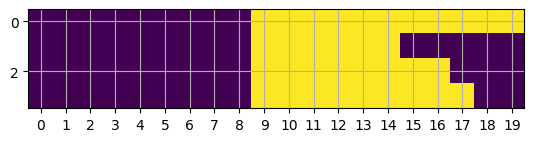

In [20]:
plt.imshow(rendered[-2])
plt.xticks(np.arange(0, rendered[-2].size(1), 1))
plt.grid()

In [21]:
from gpt2 import GPT
from torch.nn import functional as F

model = GPT.from_pretrained("gpt2")

Loading gpt2 model weights from transformers


In [69]:
num_correct_norm = 0
num_correct = 0
num_total = 0

data, tokens, mask, label = rendered

print("\n\n\n\n0. tokens:\n", tokens.shape)

# get the logits
logits, loss = model(tokens)
print("\n\n\n\n1. Logits:\n", logits.shape)
print("sentences * tokens * vocab")
print(logits)

# evaluate the autoregressive loss at all positions
# model does not output the logits for the first token, it is treated as the holy ground truth
# so we have to cut the first token -- its got not corresponding logits (cause we are not getting logits for the "empty start most probable token")
# and we have to cut the last token -- we dont care about further tokens, only want to evaluate loss for the ones given
# contiguous() is used to ensure that the memory is laid out in a contiguous block, it returns a copy if tensor is not contiguous or self otherwise
#   ways to check if copy: original.data_ptr() == contiguous.data_ptr() or id(original) == id(contiguous)
shift_logits = (logits[:, :-1, :]).contiguous()
print("\n\n\n\n2. Shift Logits:\n", shift_logits.shape)
print(logits)

shift_tokens = (tokens[:, 1:]).contiguous()
print("\n\n\n\n3. Shift Tokens:\n", shift_tokens.shape)
print(shift_tokens)

# now we have to compute the loss with respect to shift_logits
flat_shift_logits = shift_logits.view(-1, shift_logits.size(-1))
flat_shift_tokens = shift_tokens.view(-1)
shift_losses = F.cross_entropy(flat_shift_logits, flat_shift_tokens, reduction='none')
shift_losses = shift_losses.view(tokens.size(0), -1)
print("is contiguous?", shift_losses.is_contiguous())
# now get the average loss just for the completion region (where mask == 1), in each row
shift_mask = (mask[..., 1:]).contiguous() # we must shift mask, so we start at the last prompt token
masked_shift_losses = shift_losses * shift_mask
# sum and divide by the number of 1s in the mask
sum_loss = masked_shift_losses.sum(dim=1)
avg_loss = sum_loss / shift_mask.sum(dim=1)
# now we have a loss for each of the 4 completions
# the one with the lowest loss should be the most likely
pred = sum_loss.argmin().item()
pred_norm = avg_loss.argmin().item()

# accumulate stats
num_total += 1
num_correct += int(pred == label)
num_correct_norm += int(pred_norm == label)
print(f"{num_total} acc_norm: {num_correct_norm}/{num_total}={num_correct_norm/num_total:.4f}")

# debug: pretty print a few examples, and the losses in each case
if num_total < 10:
    print("---")
    print(f"Context:\n {example['ctx']}")
    print(f"Endings:")
    for i, end in enumerate(example["endings"]):
        print(f"{i} (loss: {avg_loss[i].item():.4f}) {end}")
    print(f"predicted: {pred_norm}, actual: {label}")





0. tokens:
 torch.Size([4, 20])




1. Logits:
 torch.Size([4, 20, 50257])
sentences * tokens * vocab
tensor([[[ -33.5706,  -32.7689,  -35.4510,  ...,  -40.9807,  -40.1867,
           -33.2153],
         [-105.0330, -103.2583, -110.3991,  ..., -111.8692, -104.8637,
          -105.6672],
         [-119.8807, -117.7583, -123.3105,  ..., -127.7225, -120.2321,
          -120.7401],
         ...,
         [ -98.9866,  -95.4444,  -97.4640,  ..., -108.0764, -107.3866,
          -100.0664],
         [-128.3072, -128.1642, -132.5630,  ..., -141.1546, -139.0250,
          -128.6488],
         [-108.6667, -107.1693, -107.7597,  ..., -113.0093, -113.0028,
          -103.4984]],

        [[ -33.5706,  -32.7689,  -35.4510,  ...,  -40.9807,  -40.1867,
           -33.2153],
         [-105.0330, -103.2583, -110.3991,  ..., -111.8692, -104.8637,
          -105.6672],
         [-119.8807, -117.7583, -123.3105,  ..., -127.7225, -120.2321,
          -120.7401],
         ...,
         [ -81.1260,  -85.5

In [63]:
og = shift_logits
print(og.shape)
ex = shift_logits.view(-1, shift_logits.size(-1))
print(ex.shape)

torch.Size([4, 19, 50257])
torch.Size([76, 50257])


In [45]:
import tiktoken

enc = tiktoken.get_encoding("gpt2")

enc.decode(tokens[0].tolist())

'A man is sitting on a roof. he is using wrap to wrap a pair of skis.'

In [57]:
print(enc.encode("A"))
model(tokens[0:1])

[32]


(tensor([[[ -33.5706,  -32.7689,  -35.4510,  ...,  -40.9807,  -40.1867,
            -33.2153],
          [-105.0330, -103.2583, -110.3991,  ..., -111.8692, -104.8637,
           -105.6672],
          [-119.8807, -117.7583, -123.3105,  ..., -127.7225, -120.2321,
           -120.7401],
          ...,
          [ -98.9866,  -95.4444,  -97.4640,  ..., -108.0764, -107.3866,
           -100.0664],
          [-128.3072, -128.1642, -132.5630,  ..., -141.1546, -139.0250,
           -128.6488],
          [-108.6667, -107.1693, -107.7597,  ..., -113.0093, -113.0028,
           -103.4984]]], grad_fn=<UnsafeViewBackward0>),
 None)

In [65]:
shift_losses.shape

torch.Size([4, 19])

In [68]:
import torch 

def cross_entropy(t, target):
    return -1 * torch.log(torch.exp(t[target]) / torch.exp(t).sum())

print(cross_entropy(shift_logits[0, 0], shift_tokens[0, 0]))

print(F.cross_entropy(shift_logits[0, 0].unsqueeze(0), shift_tokens[0, 0].unsqueeze(0)))

tensor(7.3022, grad_fn=<MulBackward0>)
tensor(7.3022, grad_fn=<NllLossBackward0>)


In [75]:
logits

tensor([[[ -33.5706,  -32.7689,  -35.4510,  ...,  -40.9807,  -40.1867,
           -33.2153],
         [-105.0330, -103.2583, -110.3991,  ..., -111.8692, -104.8637,
          -105.6672],
         [-119.8807, -117.7583, -123.3105,  ..., -127.7225, -120.2321,
          -120.7401],
         ...,
         [ -98.9866,  -95.4444,  -97.4640,  ..., -108.0764, -107.3866,
          -100.0664],
         [-128.3072, -128.1642, -132.5630,  ..., -141.1546, -139.0250,
          -128.6488],
         [-108.6667, -107.1693, -107.7597,  ..., -113.0093, -113.0028,
          -103.4984]],

        [[ -33.5706,  -32.7689,  -35.4510,  ...,  -40.9807,  -40.1867,
           -33.2153],
         [-105.0330, -103.2583, -110.3991,  ..., -111.8692, -104.8637,
          -105.6672],
         [-119.8807, -117.7583, -123.3105,  ..., -127.7225, -120.2321,
          -120.7401],
         ...,
         [ -81.1260,  -85.5751,  -84.7267,  ...,  -95.5109,  -93.9703,
           -84.2436],
         [ -75.6481,  -80.6936,  -79.960

In [76]:
logits[0].transpose(1, 0)

tensor([[ -33.5706, -105.0330, -119.8807,  ...,  -98.9866, -128.3072,
         -108.6667],
        [ -32.7689, -103.2583, -117.7583,  ...,  -95.4444, -128.1642,
         -107.1693],
        [ -35.4510, -110.3991, -123.3105,  ...,  -97.4640, -132.5630,
         -107.7597],
        ...,
        [ -40.9807, -111.8692, -127.7225,  ..., -108.0764, -141.1546,
         -113.0093],
        [ -40.1867, -104.8637, -120.2321,  ..., -107.3866, -139.0250,
         -113.0028],
        [ -33.2153, -105.6672, -120.7401,  ..., -100.0664, -128.6488,
         -103.4984]], grad_fn=<TransposeBackward0>)

In [83]:
# potential contiguous problems

x = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
xt = x.transpose(1, 0).contiguous()
print("is contiguous?", xt.is_contiguous())
print(xt)

y = x.view(-1)
print(y)


x = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
xt = x.transpose(1, 0)
print("is contiguous?", xt.is_contiguous())
print(xt)

y = x.view(-1)
print(y)

is contiguous? True
tensor([[1, 4, 7],
        [2, 5, 8],
        [3, 6, 9]])
tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
is contiguous? False
tensor([[1, 4, 7],
        [2, 5, 8],
        [3, 6, 9]])
tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])


In [87]:
# potential contiguous problems

torch.manual_seed(42)
x1 = torch.randn(3, 4).transpose(0, 1)  # non-contiguous
print(x1.is_contiguous())
print(x1.add_(1))  # This may not affect all elements as expected

torch.manual_seed(42)
x2 = torch.randn(3, 4).transpose(0, 1).contiguous()  # contiguous
print(x2.is_contiguous())
print(x2.add_(1))  # This will affect all elements as expected

print("are they the same?\n", x1 == x2)

False
tensor([[ 1.3367, -0.1229,  1.4617],
        [ 1.1288,  0.8137,  1.2674],
        [ 1.2345,  3.2082,  1.5349],
        [ 1.2303,  0.3620,  1.8094]])
True
tensor([[ 1.3367, -0.1229,  1.4617],
        [ 1.1288,  0.8137,  1.2674],
        [ 1.2345,  3.2082,  1.5349],
        [ 1.2303,  0.3620,  1.8094]])
are they the same?
 tensor([[True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True]])


In [88]:
masked_shift_losses

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.5087e+00, 5.8585e+00, 1.1923e+01, 2.1637e+00,
         2.7706e+00, 2.6047e+00, 5.8061e+00, 1.1112e-02, 7.5943e+00, 1.6238e+00,
         1.5568e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.5087e+00, 9.2569e+00, 1.4073e+01, 4.3877e+00,
         1.3537e+00, 4.0587e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.5087e+00, 3.0817e+00, 8.8085e-01, 1.1994e+01,
         3.4136e+00, 6.1874e-01, 5.1059e-01, 1.5803e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 5.0368e+00, 4.9301e+00, 3.0012e+00, 9.0537e+00,
         4.1260e+00, 3.9609e+00, 2.1955e+00

In [89]:
sum_loss, avg_loss

(tensor([43.4218, 34.6391, 23.5885, 36.6314], grad_fn=<SumBackward1>),
 tensor([3.9474, 5.7732, 2.9486, 4.0702], grad_fn=<DivBackward0>))